# BASICS OF MOBILE ROBOTICS
## BOMR Project

This project was made by the Group 31, made up of the following people:

### Axel Béguelin, Lou De Bel-Air, Robin Carlet, Robin Junod.

For this project of mobile robotics, we were asked to use a ThymioII robot, a camera and our project had to use the following concepts:

- Vision
- Global Navigation
- Motion Control
- Filtering
- Local Navigation

Just a quick resume of the robot. Thymio II is an educational robot in the 100 Euros price range. The robot was developed at the EPFL in collaboration with ECAL, both in Lausanne, Switzerland (wiki source). This robot has the following features:

- 2 DC-motors (and 2 Wheels)
- 39 leds
- 1 loud speaker

and has the following sensor:
- 9 infrared (IR) proximity sensors (reach about 10cm)
- 5 capacitive touch buttons
- 1 three-axis accelerometer
- 1 thermometer
- 1 microphone (recording or detection of noise)
- 1 IR receiver (for remote controller)
- 1 Wireless module

![SNOWFALL](img_presentation/img_thymio.png)

# Introduction of our project

The goal is that the Thymio can go from any position on a map to an objective. 
We decided to approch this project with the following setup. 
<div>
<img src="img_presentation/Setup.jpeg" width="300"/>
</div>

A camera above the setup is used to visualize the map on the computer. It identifies the Thymio, the obstacles and the goal. 
Then the global navigation computes the shortest path to the goal, and the motion control set the speeds of the motors to follow it.
To have a more accurate trajectory and to counter incertitudes, there is feedback on the position of the robot, which will pass through a bayesian filter.
The emplacement of the obstacles, the goal and the initial position of the Thymio can be modified before running the code.
Even if new obstacles are added on the setup after the execution of the code, the robot is able to attain the goal by evitating them using local navigation. We also want the robot to reach the goal even if it is "kidnapped".

To make the different objects easier to identify by the computer vision we used different colors and forms. The goal (red) and the obstacles (blue) for the global navigation are in two dimensions. The two green dots on the Thymio allows to know its angle as well as its position on the map.

The obstacles for local navigation are in three dimensions, such that they can be detected by the horizontal proximity sensors.


## GLOBAL NAVIGATION

We choosed to use visibility graphs, we then apply a shortest path algorithm on it (A*). To do so a class Global_Navigation is implemented.

In [2]:
class Global_Navigation:
    def __init__(self,obstacles_pos,thymio_pos,goal_pos,map_size):            
        #convert the obstacle_pos as list of lists of tuples instead list of np.ndarray of tuples for next calculations
        self.all_obstacles=[]
        for index, obstacle in enumerate(obstacles_pos):
            self.all_obstacles.append([])
            for point in obstacle:
                self.all_obstacles[index].append((point[0],point[1]))
            
        self.raw_obstacles_pos=obstacles_pos
        self.thymio_pos=(thymio_pos[0],thymio_pos[1])
        self.goal_pos=(goal_pos[0],goal_pos[1])
        self.all_nodes=[]
        self.all_nodes.append(self.thymio_pos)
        self.all_nodes.append(self.goal_pos)      
        for obstacle in self.all_obstacles:
            for node in obstacle:
                self.all_nodes.append((node[0],node[1]))
        
        self.max_valx=map_size[0]
        self.max_valy=map_size[1]
        self.nodes_neigbors={}
        self.path=[]

Objects of this class take as parameters the state of the map: position of the thymio, the goal and the obstacles that have been already virtualy expanded to make sure that the thymio does not collide with obstacles, and the size of the map.

#### Visibility graph

First of all, in order to create visibility graph, we defines, position of the thymio, 
goal and vertices (that are not too closed to the edges of the map) of the obstacles as nodes of the graph.

Then we construct links between the nodes that are not obstructed by obstacles.
To do so we distinct to cases: <br />
-create links between nodes that are not vertices of the same obstacle <br />
-create links between nodes that are vertices of the same obstacle <br />

##### Nodes that are not vertices of the same obstacle

In [3]:
def onSegment(self,p, q, r):
    if ( (q[0] <= max(p[0], r[0])) and (q[0] >= min(p[0], r[0])) and 
           (q[1] <= max(p[1], r[1])) and (q[1] >= min(p[1], r[1]))):
        return True
    return False

Global_Navigation.onSegment = onSegment

def orientation(self,p, q, r):
    # to find the orientation of an ordered triplet (p,q,r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise
    val = (float(q[1] - p[1]) * (r[0] - q[0])) - (float(q[0] - p[0]) * (r[1] - q[1]))
    if (val > 0):
        # Clockwise orientation
        return 1
    elif (val < 0):
        # Counterclockwise orientation
        return 2
    else:
        # Collinear orientation
        return 0

Global_Navigation.orientation = orientation
  
def doIntersect(self,p1,q1,p2,q2):

    # Find the 4 orientations required for 
    # the general and special cases
    o1 = self.orientation(p1, q1, p2)
    o2 = self.orientation(p1, q1, q2)
    o3 = self.orientation(p2, q2, p1)
    o4 = self.orientation(p2, q2, q1)

    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True
    # Special Cases

    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and self.onSegment(p1, p2, q1)):
        return True

    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and self.onSegment(p1, q2, q1)):
        return True

    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and self.onSegment(p2, p1, q2)):
        return True

    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and self.onSegment(p2, q1, q2)):
        return True

    # If none of the cases
    return False

Global_Navigation.doIntersect = doIntersect

For each pair of two nodes we look if any edges of every obstacles obstruct the creation a link between the nodes of this pair.
To do so in the implementation of this algorithm, the use the code for segments intersection detection of geeksforgeeks https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/ , that rely on the orientations of three given points in a certain order. If there is any intersection, any link is created, and we look for the feasibility of a link between the next pair of nodes.

##### Nodes that are vertices of the same obstacle

For nodes that are vertices of the same obstacle, looking at intersections does not work as we can see in the following example:

In [4]:
##import the image

We can see on the figure above that the segment formed with the two nodes specified by the red circles has no intersection with any other segment, however the thymio obviously can't travel from one to the other because the obstacle is between them, hence the need of using an other method for this case.

In [5]:
#import image all the case with all the loops

The figure above all the possibles orientations of: <br />
-the node 1, the node 2, and the node before the node 1 in the list of the obstacle (the vertices of the obstacle are sorted in the corresponding so their index are following the exterior contour in a "counter-clockwise" fashion)  <br />
-the node 1, the node 2, and the node after the node 1 in the list of the obstacle  <br />
-the node 1, the node after the node 1 in the list of the obstacle, and the node before the node 1 in the list of the obstacle <br />

(Note that we can define node 1 and node 2 interchangeably, it doesn't matter they are just the nodes of the paire of nodes that we want to check the feasibility of creating a link). <br />

We only have to look to the orientation between the gray line and the directs neighbor vertices because we are in the cases of the second lines, and if it happens that further edges cross the gray line, it will be detected by the segments intersection function previously seen, thus no lines link between the pair of nodes will be created. In the cases where some of the 3 orientations we look happened to be colinear, it will also be handled by the segment intersections function.

In [6]:
def find_neighbors(self,all_obstacles,all_nodes,pos_thymio,goal):


    neighbors = {node: [] for node in all_nodes}


    #if the nodes of obstacles are too close from the edges of the maps, don't add them to the visiblity graph
    nodes_close_edges=[]
    for obstacle in all_obstacles:
        for node in obstacle:
            if (node[0]< 38) or (node[0]> self.max_valx-38) or (node[1]<38) or (node[1]>self.max_valy-38):
                nodes_close_edges.append(node)
                
    for i in range(len(all_nodes)): 
        if all_nodes[i] in nodes_close_edges:
            continue
        for j in range(len(all_nodes) - i - 1):

            intersection=False

            if all_nodes[i+j+1] in nodes_close_edges:
                continue

            tmp_link1=[all_nodes[i],all_nodes[i+j+1]]

            for obstacle in all_obstacles:

                #identify when 2 vertices of the same polygon are connected
                if (all_nodes[i] in obstacle) and (all_nodes[i+j+1] in obstacle): 
                    if obstacle.index(all_nodes[i])==len(obstacle)-1:
                        if (obstacle.index(all_nodes[i+j+1]) != 0) and (obstacle.index(all_nodes[i])!=obstacle.index(all_nodes[i+j+1])+1):
                            o1=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])-1])
                            o2=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[0])
                            o3=self.orientation(all_nodes[i],obstacle[0],obstacle[obstacle.index(all_nodes[i])-1])
                            if (o1==1 and o2==2)or (o1==o2 and o3==2):
                                intersection=True
                                break
                    elif obstacle.index(all_nodes[i])==0:
                        if (obstacle.index(all_nodes[i+j+1]) != len(obstacle)-1) and (obstacle.index(all_nodes[i+j+1]) != obstacle.index(all_nodes[i])+1):
                            o1=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[len(obstacle)-1])
                            o2=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])+1])
                            o3=self.orientation(all_nodes[i],obstacle[obstacle.index(all_nodes[i])+1],obstacle[len(obstacle)-1])
                            if (o1==1 and o2==2)or (o1==o2 and o3==2):
                                intersection=True
                                break
                    else:
                        if (obstacle.index(all_nodes[i])!=obstacle.index(all_nodes[i+j+1])+1) and (obstacle.index(all_nodes[i+j+1]) != obstacle.index(all_nodes[i])+1):
                            o1=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])-1])
                            o2=self.orientation(all_nodes[i],all_nodes[i+j+1],obstacle[obstacle.index(all_nodes[i])+1])
                            o3=self.orientation(all_nodes[i],obstacle[obstacle.index(all_nodes[i])+1],obstacle[obstacle.index(all_nodes[i])-1])
                            if (o1==1 and o2==2)or (o1==o2 and o3==2):
                                intersection=True
                                break   

                #implement the segment intersection function between the current pair of nodes and all the edges of all the obstacles
                for index, vertice in enumerate(obstacle):

                    if index== len(obstacle)-1: #last point of the obstacle
                        tmp_link2=[(vertice[0],vertice[1]),(obstacle[0][0],obstacle[0][1])]
                    else:

                        tmp_link2=[(vertice[0],vertice[1]),(obstacle[index+1][0],obstacle[index+1][1])]


                    if tmp_link1[0] ==tmp_link2[0] or tmp_link1[0] ==tmp_link2[1] or tmp_link1[1] == tmp_link2[0] or tmp_link1[1] ==tmp_link2[1]:
                        continue

                    if self.doIntersect(tmp_link1[0],tmp_link1[1],tmp_link2[0],tmp_link2[1]):
                        intersection=True
                        break

                if intersection==True:
                    break

            if intersection==False:
                neighbors[all_nodes[i]].append(all_nodes[i+j+1])
                neighbors[all_nodes[i+j+1]].append(all_nodes[i])

    return neighbors

Global_Navigation.find_neighbors = find_neighbors

#### Find the shortest path

The A* algorithm is implemented because compared to the dijkstra algorithm it happens to be much faster, need to visit much less nodes of the graph in order to find the right path.

In [7]:
def h_vertices_obstacles(self,coords,goal):
    k=[]
    for vertex in coords:
        k.append(math.dist(vertex,goal))
        h = dict(zip(coords, k))
    return h

Global_Navigation.h_vertices_obstacles = h_vertices_obstacles

The function above is in charge of defining the heuristic function as the distance from the nodes of the graph to the goal.

In [8]:
def reconstruct_path(self,cameFrom, current):

    total_path = [current] 

    while current in cameFrom.keys():

        total_path.insert(0, cameFrom[current])  
        current=cameFrom[current]

    return total_path

Global_Navigation.reconstruct_path = reconstruct_path

The function above return the list of nodes to go to a certain node from the goal, used to get the path to the goal in the A* algorithm 

In [9]:
def A_Star(self,start, goal, h_vertices_obstacles, coords, nodes_neigbors,max_valx,max_valy):


    for point in [start, goal]:
        assert point[0]>=0 and point[0]<max_valx and point[1]>=0 and point[1]<max_valy ,"start or end goal not contained in the map"


    openSet = [start]

    closedSet = []

    cameFrom = dict()

    gScore = dict(zip(coords, [np.inf for x in range(len(coords))])) 
    gScore[start] = 0 

    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = math.dist(goal,start)



    while openSet != []: 
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet 

        if current == goal:
            return self.reconstruct_path(cameFrom, current)

        openSet.remove(current)
        closedSet.append(current)

        for neighbor in nodes_neigbors[current]: 


            if (neighbor in closedSet): 
                continue


            tentative_gScore = gScore[current] + math.dist(current,neighbor) 

            if neighbor not in openSet:
                openSet.append(neighbor) 

            if tentative_gScore < gScore[neighbor]:
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h_vertices_obstacles[neighbor]


    print("No path found to goal")
    return [], closedSet

Global_Navigation.A_Star = A_Star

The A* is implemented in the function above, the weight to travel from one node to an otheris is the distance between these two nodes

In [10]:
def create_path(self):           
    self.nodes_neigbors=self.find_neighbors(self.all_obstacles,self.all_nodes,self.thymio_pos,self.goal_pos)

    self.path=self.A_Star(self.thymio_pos, self.goal_pos, self.h_vertices_obstacles(self.all_nodes,self.goal_pos), self.all_nodes,self.nodes_neigbors ,self.max_valx,self.max_valy)
    return self.path

Global_Navigation.create_path = create_path

The function above is the one used to obtaine the shortest path after having inialized an object of the class Global_Navigation.

#### Plots

In [11]:
def plot_visibility_graph(self):
    Img=np.zeros((self.max_valy, self.max_valx,3), dtype='uint8')

    for obstacle in self.raw_obstacles_pos:
        cv2.polylines(Img, [obstacle.reshape((-1, 1, 2))], True, (255,255,0), 5) 

    cv2.circle(Img, (round(self.goal_pos[0]),round(self.goal_pos[1])), 5, (255, 0, 0), 5)
    cv2.circle(Img, (round(self.thymio_pos[0]),round(self.thymio_pos[1])), 5, (0, 0, 255), 5)

    for node in self.nodes_neigbors:
        for neighbor in self.nodes_neigbors[node]:
            image = cv2.line(Img, (round(node[0]),round(node[1])), (round(neighbor[0]),round(neighbor[1])), (100, 100, 255), 2)
    plt.imshow(image) 
    
Global_Navigation.plot_visibility_graph = plot_visibility_graph

In [12]:
def plot_shortest_path(self):
    Img=np.zeros((self.max_valy, self.max_valx,3), dtype='uint8')
    for obstacle in self.raw_obstacles_pos:
        image = cv2.polylines(Img, [obstacle.reshape((-1, 1, 2))], True, (255,255,0), 5) 
    cv2.circle(Img, (round(self.goal_pos[0]),round(self.goal_pos[1])), 5, (255, 0, 0), 5)
    cv2.circle(Img, (round(self.thymio_pos[0]),round(self.thymio_pos[1])), 5, (0, 0, 255), 5)

    cv2.polylines(Img, np.int32([np.array(self.path).reshape((-1, 1, 2))]), False, (200, 0, 255), 3) 

    plt.imshow(image)
    
Global_Navigation.plot_shortest_path = plot_shortest_path

## Motion Control

For the motion control, we used a PID controller that was used to smooth the robot trajectory. This PID controller is working on the angle error between the direction of the robot and the goal direction. A PI controller would have been probabely sufficiant but we decided to use a PID to have more freedom for the tuning.

This PID controller is comparing the angle error and give as output a 'rotation' delta speed. This rotation speed will then be add/substated to the left and right motor speed. To have something has bellow:
<div>
<img src="img_presentation/pid_resume.png" width="300"/>
</div>

For the computation of the angle error, we need the follwing information:
- robot position
- angle of the robot
- goal position

We represent the postion in the classical cartesian coordinates (x,y). The angle of the thymio(alpha) and the angle of the goal(alpha_goal) as 'absolut angle'. The vector (1,0) has the angle 0 (the vector (0,1) as the angle pi/2 etc...). The angle is negative in clockwise direction. The angle error is always represented in the range : [-pi , pi], This way, the PID controller is easy to implement. The image below is presenting the general idea of the PID implementation:

<div>
<img src="img_presentation/PID_details.png" width="500"/>
</div>

The motion control part is made in a class of .py file. For further information, go look at the script: functiion.MotionControl.py.

In [9]:
import function.MotionControl as MotionControl
import matplotlib.pyplot as plt
import math

C:\Users\Robin\AppData\Local\Temp\ipykernel_12920\2648113115.py:53: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(['Thymio trajectry', None, None,'objective path', 'Thymio starting direction'], handles=[traj, path, angle])


AttributeError: 'list' object has no attribute 'get_label'

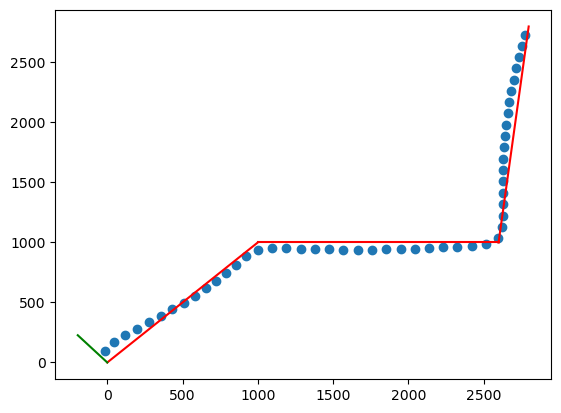

In [22]:
# Here is an exemple trajectory of the implemetation of the PID without the filtered feedback about the position and angle.
# For this exemple, we take only the 

goals_list = [(1000,1000), (2600,1000),(2800,2800)]
n_goal = 0
goal_pos = list(goals_list[n_goal])

init_robot_angle = -4
robot_speed = [100,100]
robot_angle = -4
robot_pos = [0,0]

d_time = 3
thymio_trajectory = []

# Create PID controller
PID = MotionControl.MotionControl()
PID.update_angle_error(robot_angle, robot_pos, goals_list[n_goal])
# loop
loop = 0
while True:
    loop += 1
    goal_achieved = False
    # compute error
    PID.update_angle_error(robot_angle, robot_pos, goal_pos)
    # compute PID speed
    [robot_speed[0], robot_speed[1]] = PID.PID(d_time, 100, 100)
    # set speed and get new position and angle value
    [robot_pos[0], robot_pos[1], robot_angle] = PID.plant(robot_speed[0], robot_speed[1], robot_pos[0], robot_pos[1], robot_angle, d_time)
    thymio_trajectory.append((robot_pos[0], robot_pos[1]))
    
    # Check proximity
    manathan_dist_to_goal = abs(goal_pos[1]-robot_pos[1]) + abs(goal_pos[0]-robot_pos[0])
    if manathan_dist_to_goal < 200 or loop > 300:
        n_goal += 1
        if n_goal < len(goals_list):
            goal_pos = list(goals_list[n_goal])
            # reset integral value
            PID.PID_integral = 0
        else:
            break

# plot trajectorie
plt.scatter(*zip(*thymio_trajectory), label='traj')

# Plot objective 'path'
plt.plot([0,goals_list[0][0]], [0,goals_list[0][1]], color = 'red', linestyle = 'solid', label='path')
plt.plot([goals_list[0][0],goals_list[1][0]], [goals_list[0][1],goals_list[1][1]], color = 'red', linestyle = 'solid')
plt.plot([goals_list[1][0],goals_list[2][0]], [goals_list[1][1],goals_list[2][1]], color = 'red', linestyle = 'solid')

plt.plot([0,300*math.cos(init_robot_angle)], [0, 300 * math.sin(init_robot_angle)], color = 'green', label='angle')

plt.legend(['Thymio trajectry', None, None,'objective path', 'Thymio starting direction'], handles=[traj, path, angle])

plt.title('Thymio PID direction')

# Local Navigation

The goal of local navigation is that the Thymio evitate new obstacles put on its path.

We decided to use the approach of Artificial Neural Networks (ANN).

First a function is used to detect the obstacles using horizontal proximity sensors because new obstacles are in three-dimensions.


In [ ]:
def detect_obstacle(self, proximity_sensors, threshold=100):  
    self.prox_horizontal = proximity_sensors[0:4] 
    maxvalue = max(self.prox_horizontal)
    if(maxvalue > threshold) : 
        detect = True
    else :
        detect = False
    return detect


When horizontal proximity sensors detect an obstacle, we compute the speed of the motors such that the robot turns and is not anymore in front of the obstacle. 

Articificial Neural Networks is a good approach for that goal because depending on the distance from the obstacle and the values of the proximity sensors it will adapt its rotation speed and time to perform one of the most optimal trajectory to bypass the obstacle.

Formulas

The weight were set experimentally.


In [ ]:
def turn_if_obstacle(self, proximity_sensors): 
    self.prox_horizontal = proximity_sensors[0:4] 
    w_l = [20,  30, -30, -30, -20]
    w_r = [-20, -30, 30,  30,  20]

    # Scale factors for sensors 
    sensor_scale = 400

    y = [0,0]
    x = [0,0,0,0,0]
    

    
    for i in range(0,len(x)-1):
        # Get and scale inputs
        x[i] = self.prox_horizontal[i] // sensor_scale
        
        # Compute outputs of neurons and set motor powers
        y[0] = y[0] + x[i] * w_l[i]
        y[1] = y[1] + x[i] * w_r[i]    

    # Set motor powers
    motor_left_target = y[0]
    motor_right_target = y[1]

    return [motor_left_target,motor_right_target]


Then the robot follows a curvilinear trajectory in the goal direction. 

It is done by setting a lower speed for the wheel the closest to the obstacle. 


In [ ]:
def curvilinear_traj(self, speeds) :
    NOMINAL_SPEED = 160
    DELTA_SPEED = 60
    if(speeds[0]<speeds[1]) :
        motor_left_target = NOMINAL_SPEED
        motor_right_target = NOMINAL_SPEED - DELTA_SPEED
    else :
        motor_left_target = NOMINAL_SPEED - DELTA_SPEED
        motor_right_target = NOMINAL_SPEED

    return [motor_left_target,motor_right_target]

When the robot is sufficiently far from the obstacle, it goes back in the main loop, to recompute the new trajectory to go to next point in the path (see section main).

# Threading and code organisation

# Odometry